In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import MultiPoint

In [5]:
from math import ceil, floor, sin, cos, sqrt
from enum import Enum
class Dataset(Enum):
    AND_GRID = 0 #Basic AND function
    BASIC_GRID = 1 #Basic grid 4x4 with 8xO and 8xX
    BOOL_FUNC = 2 #Boolean function of 5 variables
    POLYGON = 3 #Polygon shape dividing 2D grid to 2 classes
    MULTI_CLASS = 4 #Function dividing 2D grid to 8 classes
    ONE_DIM = 5 #One dimensional function
    ONE_DIM_MEMORY = 6 #One dimensional function with memory
    
class Memory_func_inputs(Enum):
    Sine = 1
    Binary = 2
    Noise = 3
    
    def input(self, t):
        if self == Memory_func_inputs.Sine:
            return sin(t)
        elif self == Memory_func_inputs.Binary:
            x = 0
            t = t%55
            if(t > 5 and t < 10) or (t > 20 and t < 30) or (t>35 and t <45):
                x = 1
            return x
        elif self == Memory_func_inputs.Noise:
            return np.random.randint(low=0, high=5)
        else: return -1

In [6]:
polygon_coords = [(0.5,0.5),(1,2.5),(2.5,4),(3,3),(2.5,2.5),(3.5,1),(2.5,0),(2,2),(1.5,1),(0.5,0.5)]
#polygon = MultiPoint(polygon_coords).convex_hull
polygon = Polygon(polygon_coords)

In [7]:
def get_top_left_corner(point):
    #Returns top left coords of a square the point belongs to
    top_left = []
    top_left.append(floor(point[0]))
    top_left.append(ceil(point[1]))
    return top_left

def get_multi_class_label(point):
    top_left_corner = get_top_left_corner(point)
    x = top_left_corner[0]
    y = top_left_corner[1]
    label = x
    if y == 1 or y == 3:
        label = x + 4
    if label > 7: label = 7
    return label

one_dim_memory_inputs = []

def get_true_label(point, dataset):
    label = 0
    if dataset == Dataset.POLYGON:
        if Point(point).within(polygon):
            label = 1
    elif dataset == Dataset.AND_GRID:
        if point[0] >= 2 and point[1] >= 2:
            label = 1
            
    elif dataset == Dataset.MULTI_CLASS:
        label = get_multi_class_label(point)
    
    elif dataset == Dataset.BASIC_GRID:
        l = get_multi_class_label(point)
        if l in [0,1,3,5]:
            label = 1
            
    elif dataset == Dataset.BOOL_FUNC:
        if len(point) != 5 or point[0] not in [0,1]:
            print("Point must be 5D and 0 or 1!")
        else:
            val = point[0] + point[1]*2 + point[2]*4 + point[3]*8 + point[4]*16
            if val in [0,3,7,12,14,15,16,17,25,30]:
                label = 1
                
    elif dataset == Dataset.ONE_DIM:
        x = point
        return sin(x*x)
    
    elif dataset == Dataset.ONE_DIM_MEMORY:
        one_dim_memory_inputs.append(point)
        x = one_dim_memory_inputs # all previous inputs
        n = len(x) # number of all previous inputs
        h = 7 # size of window = number of past inputs taken into consideration
        k = [0.5, 2, 1.4, 1, 0.7, 0.2, 1.3] # coefficients = weights of previous inputs
        d = 1 # step size when going over previous inputs
        
        y_n = 0
        for i in range(h):
            idx = (n - i*d) - 1
            if idx < 0: 
                break; # the size of window will stretch from 1 to h over time as size of x grows
            #print("idx = ",idx,"x=",x,"n=",n)
            y_n += x[idx] * k[i]
        return y_n

    else:
        print("Not implemented.")
        
    return label

In [8]:
def generate_grid_points(count_per_side):
    size_x = 4
    size_y = 4
    xs = np.linspace(0,size_x, count_per_side)
    ys = np.linspace(0,size_y, count_per_side)
    xv, yv = np.meshgrid(xs, ys)
    points = np.array(np.zeros(shape=(3,xv.flatten().shape[0]), dtype=float))
    points[0] = xv.flatten()
    points[1] = yv.flatten()
    return points

def get_grid_points_with_labels(count_per_side, dataset):
    points = generate_grid_points(count_per_side)
    labels = []
    for i in range(len(points[0])):
        point = [points[0][i], points[1][i]]
        label = get_true_label(point, dataset)
        labels.append(label)

    points[2] = np.array(labels)
    return points

def plot_dataset(dataset):
    if dataset in [Dataset.POLYGON, Dataset.MULTI_CLASS, Dataset.BASIC_GRID, Dataset.AND_GRID]:
        points = get_grid_points_with_labels(100, dataset)
        plt.scatter(points[0],points[1],c=points[2])
        plt.show()
    elif dataset == Dataset.ONE_DIM:
        xs = np.linspace(0, 8, 10000)
        labels = []
        for x in xs:
            labels.append(get_true_label(x, dataset))
        plt.plot(xs,labels, 'b-')
        plt.show()
    elif dataset == Dataset.ONE_DIM_MEMORY:
        for memory_input in Memory_func_inputs:
            one_dim_memory_inputs[:] = []
            ts = np.linspace(0, 50, 50)
            inputs = []
            outputs = []
            for t in ts:
                x = memory_input.input(t)
                inputs.append(x)
                outputs.append(get_true_label(x, dataset))

            plt.figure(1)
            plt.subplot(211)
            plt.ylabel('inputs')
            plt.plot(ts,inputs, 'b-')

            plt.subplot(212)
            plt.ylabel('outputs')
            plt.plot(ts,outputs, 'b-')
            plt.show()
            
    elif dataset == Dataset.BOOL_FUNC:
        print("IF value IN [0,3,7,12,14,15,16,17,25,30]: label = 1 ELSE label = 0")
    else:
        print("Not implemented yet.")

In [9]:
def get_train_data(dataset, number_of_points, save_to_file=False):
    xs = []
    ys = []
    if dataset in [Dataset.POLYGON, Dataset.MULTI_CLASS, Dataset.BASIC_GRID, Dataset.AND_GRID]:
        points = get_grid_points_with_labels(floor(sqrt(number_of_points)), dataset)
        points = points.T
        xs = points[:,0:2]
        ys = points[:,2]
    elif dataset == Dataset.ONE_DIM:
        xs = np.linspace(0, 8, number_of_points)
        ys = np.array([get_true_label(x, dataset) for x in xs])
    elif dataset == Dataset.ONE_DIM_MEMORY:
        one_dim_memory_inputs[:] = []
        xs = np.array([Memory_func_inputs.Binary.input(t) for t in range(number_of_points)])
        ys = np.array([get_true_label(x, dataset) for x in xs])
    else:
        print(dataset.name, "does not have train data yet.")
    if save_to_file and len(xs) > 0:
        np.savetxt(dataset.name + "_" + str(len(xs)) + "_xs.txt", xs, fmt='%5.5f')
        np.savetxt(dataset.name + "_" + str(len(xs)) + "_ys.txt", ys, fmt='%5.5f')
        print("Saved", dataset.name, "to file.")
    return xs, ys

In [11]:
for dataset in Dataset:
    get_train_data(dataset, 10000, True)

Saved AND_GRID to file.
Saved BASIC_GRID to file.
BOOL_FUNC does not have train data yet.
Saved POLYGON to file.
Saved MULTI_CLASS to file.
Saved ONE_DIM to file.
Saved ONE_DIM_MEMORY to file.


### 0. Dataset: AND function

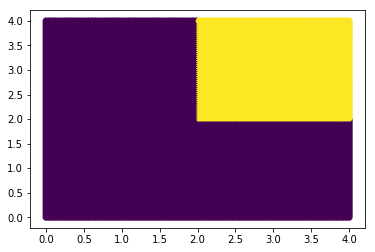

In [19]:
plot_dataset(Dataset.AND_GRID)

### 1. Dataset: Basic 4x4 grid with 2 classes

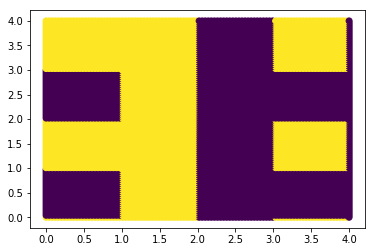

In [9]:
plot_dataset(Dataset.BASIC_GRID)

### 2. Dataset: Boolean function of 5 variables = 32 possible values

In [10]:
plot_dataset(Dataset.BOOL_FUNC)

IF value IN [0,3,7,12,14,15,16,17,25,30]: label = 1 ELSE label = 0


### 3. Dataset: Polygon shape dividing the 2D space into 2 classes

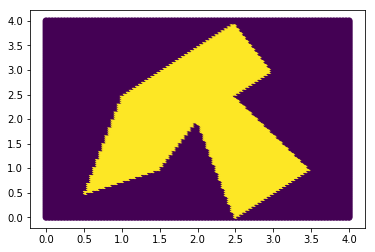

In [11]:
plot_dataset(Dataset.POLYGON)

### 4. Dataset: 2D space divided into 8 classes

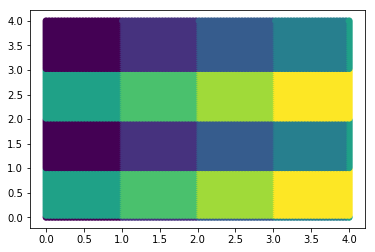

In [10]:
plot_dataset(Dataset.MULTI_CLASS)

### 5. Dataset: Moderately complicated 1D function

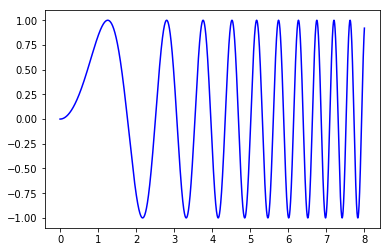

In [13]:
plot_dataset(Dataset.ONE_DIM)

### 6. Dataset: 1D function with memory

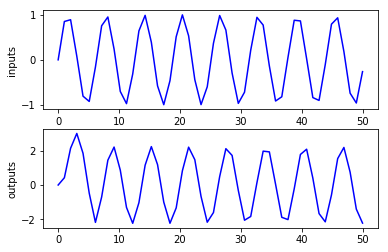

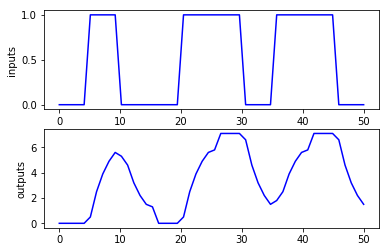

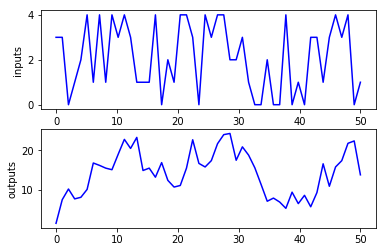

In [14]:
plot_dataset(Dataset.ONE_DIM_MEMORY)